# PSII Tutorial 

PSII images (3 in a set; F0, Fmin, and Fmax) are captured directly following a saturating fluorescence pulse 
(red light; 630 nm). These three PSII images can be used to calculate Fv/Fm (efficiency of photosystem II) 
for each pixel of the plant. Unfortunately, our PSII imaging cabinet has a design flaw when capturing images 
of plants with vertical architecture. You can read more about how we validated this flaw using our PSII 
analysis workflows in the [PlantCV Paper](http://dx.doi.org/10.1016/j.molp.2015.06.005).

To run a PSII workflow over a single PSII image set (3 images) there are 4 required inputs:

1.  **Image 1:** F0 (a.k.a Fdark/null) image.
2.  **Image 2:** Fmin image.
3.  **Image 3:** Fmax image. 
5.  **Output directory:** If debug mode is set to 'print' output images from each step are produced.

In [1]:
# Import libraries 
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.image = "../img/tutorial_images/psII/PSII_PSD_supopt_temp_btx623_22_rep1.DAT"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "psII_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


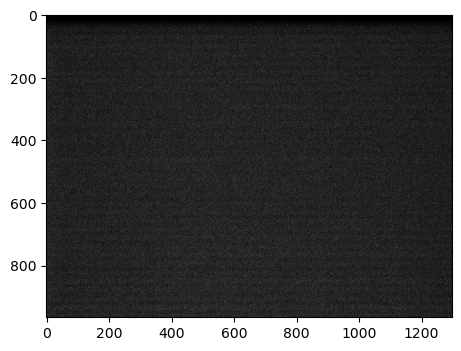

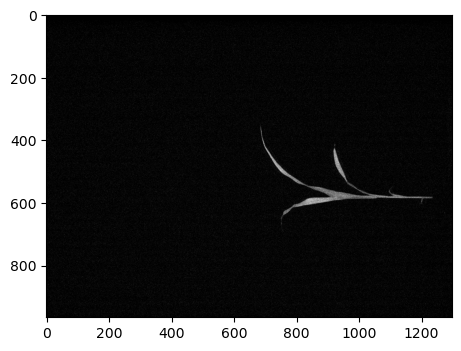

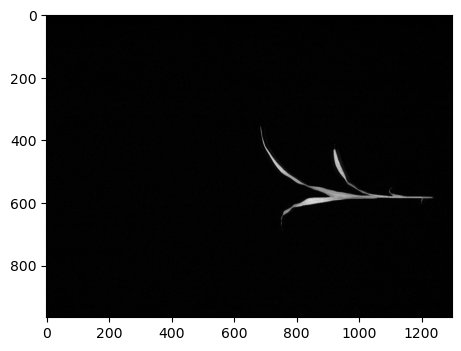

In [3]:
# Read fluorescence image data

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
fdark1, fmin1, fmax1 = pcv.photosynthesis.read_cropreporter(args.image)



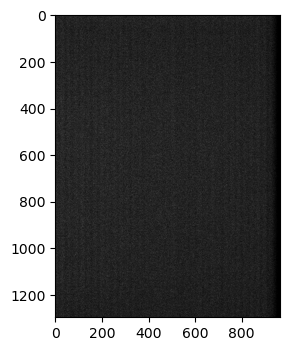

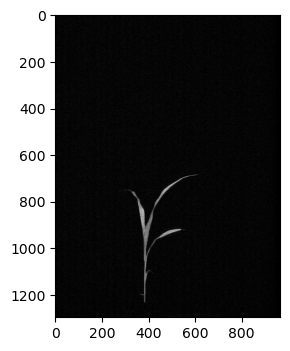

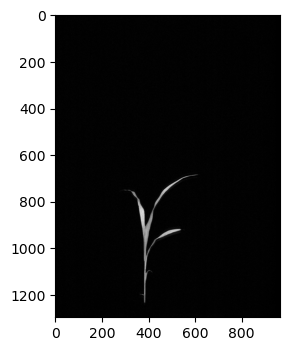

In [15]:
# Rotate each frame so that plant is upright

# Inputs:
#   img             - Image data
#   rotation_deg    - Rotation angle in degrees, can be a negative number, positive values move counter clockwise
#   crop            - If crop is set to True, image will be cropped to original image dimensions. If set to False, the image size will be adjusted to accommodate new image dimensions.
fdark = pcv.transform.rotate(img=fdark1, rotation_deg=-90, crop=False)
fmin = pcv.transform.rotate(img=fmin1, rotation_deg=-90, crop=False)
fmax = pcv.transform.rotate(img=fmax1, rotation_deg=-90, crop=False)


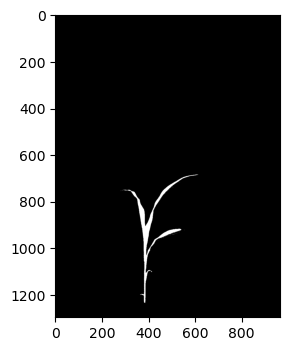

In [5]:
# Threshold the `fmax` image

# Inputs:
#   gray_img        - Grayscale image data
#   threshold       - Threshold value (usually between 0-255)
#   max_value       - Value to apply above threshold (255 = white)
#   object_type     - 'light' (default) or 'dark'. If the object is lighter than the
#                       background then standard threshold is done. If the object is
#                       darker than the background then inverse thresholding is done.
plant_mask = pcv.threshold.binary(gray_img=fmax, threshold=855, max_value=255, object_type="light")


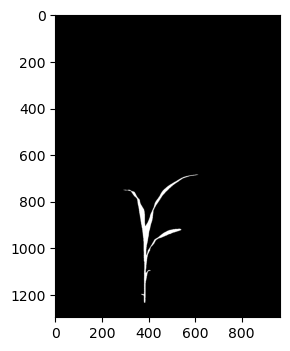

In [6]:
# Fill small objects

# Inputs:
#   bin_img         - Binary image data
#   size            - Minimum object area size in pixels (integer), smaller objects get filled in.
cleaned_mask = pcv.fill(bin_img=plant_mask, size=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


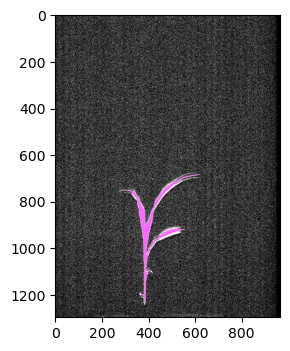

In [7]:
# Identify objects

# Inputs:
#   img             - RGB or grayscale image data for plotting
#   mask            - Binary mask used for detecting contours
id_objects, obj_hierarchy = pcv.find_objects(img=fmax, mask=cleaned_mask)

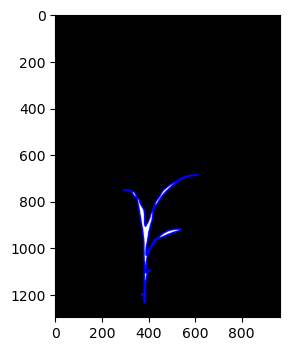

In [8]:
# Object combine kept objects

# Inputs:
#   img - RGB or grayscale image data for plotting
#   contours        - Contour list
#   hierarchy       - Contour hierarchy array
obj, masked = pcv.object_composition(img=cleaned_mask, contours=id_objects, hierarchy=obj_hierarchy)



Now we can analyze the plant objects for traits such as shape, or PSII signal. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


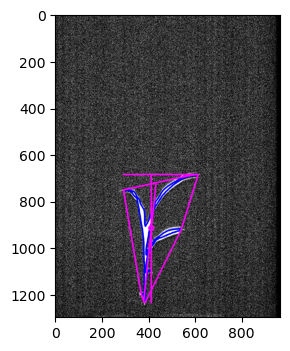

In [9]:
################ Analysis ################  

# Find shape properties, output shape image (optional)

# Inputs:
#   img             - RGB or grayscale image data
#   obj             - Single or grouped contour object
#   mask            - Binary image mask to use as mask for moments analysis
#   label           - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

shape_img = pcv.analyze_object(img=fmax, obj=obj, mask=cleaned_mask, label="default")



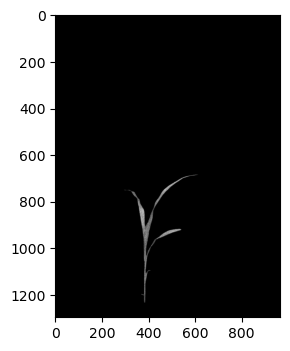

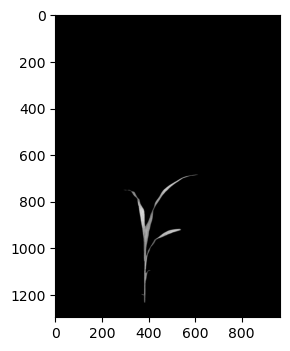

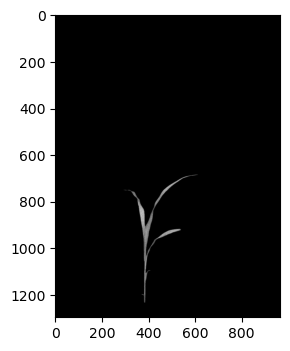

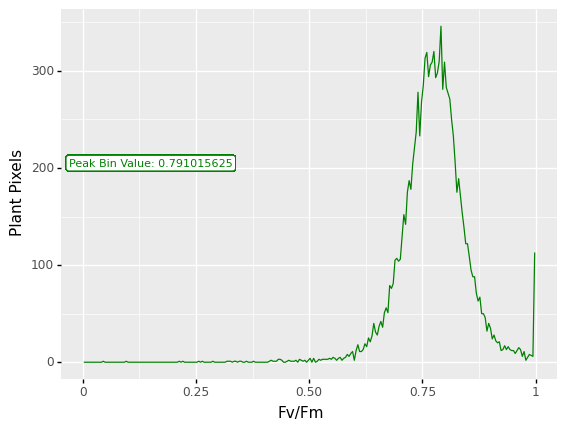

In [10]:
# Analyze fv/fm fluorescence properties

# Inputs:
#   fdark           - Grayscale image
#   fmin            - Grayscale image
#   fmax            - Grayscale image
#   mask            - Binary mask of selected contours
#   bins            - Number of grayscale bins (0-256 for 8-bit img, 0-65536 for 16-bit). Default bins = 256
#   label           - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

fvfm_images = pcv.photosynthesis.analyze_fvfm(fdark=fdark, fmin=fmin, fmax=fmax, mask=cleaned_mask, bins=256, label="default")


In [11]:
# Store the two fv_fm images
fvfm_img = fvfm_images[0]
fvfm_hist = fvfm_images[1]

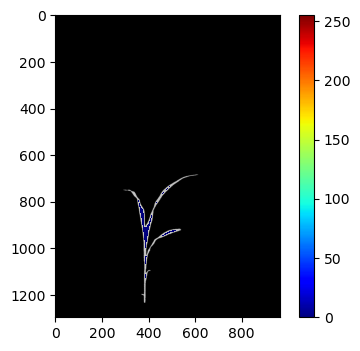

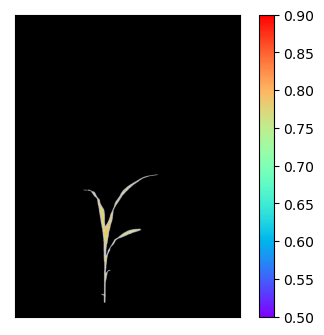

In [12]:
# Pseudocolor the Fv/Fm grayscale image that is calculated inside the fluor_fvfm function

# Inputs:
#     gray_img      - Grayscale image data
#     obj           - Single or grouped contour object (optional), if provided the pseudocolored image gets cropped down to the region of interest.
#     mask          - Binary mask (optional)
#     background    - Background color/type. Options are "image" (gray_img), "white", or "black". A mask must be supplied.
#     cmap          - Colormap (https://matplotlib.org/tutorials/colors/colormaps.html)
#     min_value     - Minimum value for range of interest
#     max_value     - Maximum value for range of interest
#     dpi           - Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
#     axes          - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
#     colorbar      - If False then the colorbar won't be displayed (default colorbar=True)
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=fvfm_img, mask=cleaned_mask, cmap='jet')

simple_pseudo_img = pcv.visualize.pseudocolor(gray_img=fvfm_img, obj=None, mask=cleaned_mask, background="image", 
                                              axes=False, cmap='rainbow', min_value=0.5, max_value=0.9)


In [13]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)



To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) Open the file named “psII_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 


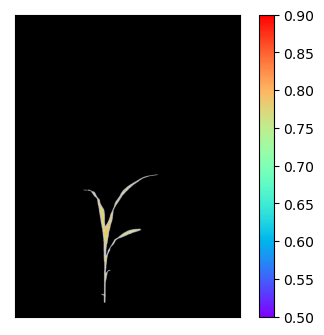

In [19]:
simple_pseudo_img = pcv.visualize.pseudocolor(gray_img=fvfm_img, obj=None, mask=cleaned_mask, background="image", 
                                              axes=False, cmap='rainbow', min_value=0.5, max_value=0.9)
pcv.params.dpi = 300
pcv.print_image(simple_pseudo_img, "photosynthesis_tutorial_card.png")